# Linear Regression

This notebook implement linear regression on the data set


## 0 Load Libraries and Data

Import the necessary libraries and load the dataset.

In [10]:
# Linear Regression for ESG Score Prediction

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')
import time

# Define a dictionary to store model metrics
model_metrics = {}

# Create an output directory for our results
os.makedirs('linreg_eval_metrics', exist_ok=True)

# After running all your models and having model_metrics dictionary populated
from thesis_visualizations import visualize_complete_results

# 1. Data Loading and Preparation

In [11]:
# 1.1. Set up data paths
class Location:
    """
    Helper class for managing file paths.
    """
    def __init__(self, base_dir):
        """
        Initialize with the base directory.
        """
        self.base_dir = base_dir
        
    def get_path(self, subdirectory, filename):
        """
        Get full path for a file in a subdirectory.
        """
        return os.path.join(self.base_dir, subdirectory, filename)

base_dir = os.getcwd()    
location = Location(base_dir)

In [12]:
# 1.2. Load column lists
subdirectory='pkl'
with open(location.get_path(subdirectory, 'base_columns.pkl'), 'rb') as f:
    base_columns = pickle.load(f)

with open(location.get_path(subdirectory, 'yeo_columns.pkl'), 'rb') as f:
    yeo_columns = pickle.load(f)

print("Base Columns (sample):", base_columns[:5])
print("Yeo Columns (sample):", yeo_columns[:5])

Base Columns (sample): ['market_cap_usd', 'net_income_usd', 'hist_pe', 'hist_book_px', 'hist_fcf_yld']
Yeo Columns (sample): ['yeo_joh_market_cap_usd', 'yeo_joh_net_income_usd', 'yeo_joh_hist_pe', 'yeo_joh_hist_book_px', 'yeo_joh_hist_fcf_yld']


In [13]:
# 1.3. Load feature and target data
subdirectory = 'data'
feature_path = location.get_path(subdirectory, 'combined_df_for_ml_models.csv')
feature_df = pd.read_csv(feature_path, index_col='issuer_name')
feature_df = feature_df.convert_dtypes()
feature_df.sort_index(ascending=True, inplace=True)

score_path = location.get_path(subdirectory, 'score.csv')
score_df = pd.read_csv(score_path, index_col='issuer_name')
score_df = score_df.convert_dtypes()
score_df.sort_index(ascending=True, inplace=True)

In [14]:
print("Feature data shape:", feature_df.shape)
print("Score data shape:", score_df.shape)
print("\nScore data preview:")
score_df.head()

Feature data shape: (2202, 388)
Score data shape: (2202, 1)

Score data preview:


,esg_score
issuer_name,
10X Genomics Inc,4.6
3I GROUP PLC,9.7
3M COMPANY,9.5
A. O. SMITH CORPORATION,4.8
A.P. MOELLER - MAERSK A/S,7.6


In [15]:
# 1.4. Create feature sets and target variable
LR_Base = feature_df[base_columns]
LR_Yeo = feature_df[yeo_columns]
y = score_df
print("Base feature data shape:", LR_Base.shape)
print("Yeo data shape:", LR_Yeo.shape)



Base feature data shape: (2202, 362)
Yeo data shape: (2202, 362)


In [16]:
# Create copies with random variables added
LR_Base_random = LR_Base.copy()
LR_Yeo_random = LR_Yeo.copy()

# Add random variables to the copies
np.random.seed(42)  # For reproducibility
LR_Base_random['random_feature'] = np.random.normal(0, 1, size=LR_Base.shape[0])
LR_Yeo_random['random_feature'] = np.random.normal(0, 1, size=LR_Yeo.shape[0])

print("Created new datasets with random features")
print(f"X_base_random shape: {LR_Base_random.shape}")
print(f"X_yeo_random shape: {LR_Yeo_random.shape}")

Created new datasets with random features
X_base_random shape: (2202, 363)
X_yeo_random shape: (2202, 363)


# 2. Model Training and Evaluation Function

In [17]:
# Assume model_metrics is a global dict for storing summary results
model_metrics = {}

def run_regression_model(X_data, y_data, model_name, 
                         model_type="linear", 
                         alpha=None, l1_ratio=None,
                         random_state=42, test_size=0.2):
    """
    Run regression on the provided data and evaluate performance.
    
    Parameters:
    -----------
    X_data : pandas.DataFrame
        Feature data
    y_data : pandas.Series or DataFrame
        Target variable
    model_name : str
        Identifier for the model
    model_type : str, default="linear"
        Type of model: "linear" or "elasticnet"
    alpha : float, optional
        Regularization strength (used if model_type == "elasticnet")
    l1_ratio : float, optional
        L1/L2 mixing ratio (used if model_type == "elasticnet")
    random_state : int, default=42
        Reproducibility seed
    test_size : float, default=0.2
        Proportion of data for testing
    """

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=test_size, random_state=random_state
    )

    # Select and initialize model
    if model_type == "linear":
        model = LinearRegression()
    elif model_type == "elasticnet":
        if alpha is None or l1_ratio is None:
            raise ValueError("ElasticNet requires both alpha and l1_ratio.")
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=random_state)
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Logging
    print(f"\nModel: {model_name}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  MSE : {mse:.4f}")
    print(f"  R²  : {r2:.4f}")

    # Store metrics globally
    model_metrics[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }


In [18]:
model_metrics

{}

# 3. Permutation Importance Calculation and Visualization

# 4. Run Models and Compare Performance

In [19]:
%%time

# Run All Models and Compare Performance
print("\n" + "="*50)
print("Running Linear Regression on All Feature Sets")
print("="*50)

# Define all datasets to use
dataset_configs = [
    {'data': LR_Base, 'name': 'LR_Base'},
    {'data': LR_Yeo, 'name': 'LR_Yeo'},
    {'data': LR_Base_random, 'name': 'LR_Base_Random'},
    {'data': LR_Yeo_random, 'name': 'LR_Yeo_Random'}
]

# Dictionary to store all results
all_results = {}

# Run regression on each dataset
for config in dataset_configs:
    print(f"\nProcessing dataset: {config['name']}")
    run_regression_model(config['data'], y, model_name=config['name'])
    all_results[config['name']] = model_metrics[config['name']]


Running Linear Regression on All Feature Sets

Processing dataset: LR_Base

Model: LR_Base
  RMSE: 3.4712
  MAE : 1.6950
  MSE : 12.0495
  R²  : -2.2744

Processing dataset: LR_Yeo

Model: LR_Yeo
  RMSE: 1.8675
  MAE : 1.4964
  MSE : 3.4876
  R²  : 0.0522

Processing dataset: LR_Base_Random

Model: LR_Base_Random
  RMSE: 3.1097
  MAE : 1.6626
  MSE : 9.6701
  R²  : -1.6279

Processing dataset: LR_Yeo_Random

Model: LR_Yeo_Random
  RMSE: 1.8674
  MAE : 1.4963
  MSE : 3.4872
  R²  : 0.0523
CPU times: user 5 s, sys: 25.8 ms, total: 5.03 s
Wall time: 354 ms


# 5. Compare Models and Visualize Results


# Elastic net

In [20]:
%%time

# Suppress all warnings
warnings.filterwarnings('ignore')

print("\n" + "="*50)
print("Finding Optimal ElasticNet Parameters for All Datasets")
print("="*50)

# Hyperparameter grid
lamb = 10 ** np.linspace(-1, 0.2, 15)  # Regularization strengths (alpha)
ratio = np.linspace(0, 1, 10)          # L1/L2 mixing (l1_ratio)

# All datasets and target
datasets = [LR_Base, LR_Yeo, LR_Base_random, LR_Yeo_random]
dataset_names = ['LR_Base', 'LR_Yeo', 'LR_Base_random', 'LR_Yeo_random']
target = score_df

# Storage for results
results_summary = []

# Iterate through datasets
for idx, X in enumerate(datasets):
    print(f"\nProcessing dataset: {dataset_names[idx]}...")
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, test_size=0.2, random_state=42
    )

    # Grid search with cross-validation
    get_results = []
    
    for la in lamb:
        for r in ratio:
            # Wrap in try-except to handle any issues
            try:
                scores = cross_val_score(
                    ElasticNet(alpha=la, l1_ratio=r, random_state=42, max_iter=10000),
                    X_train, y_train,
                    scoring='neg_mean_squared_error',
                    cv=5, n_jobs=-1
                )
                rmse_folds = np.sqrt(-scores)
                mean_rmse = np.mean(rmse_folds)
                get_results.append((la, r, mean_rmse, rmse_folds))

            except Exception as e:
                print(f"  Warning: Error with alpha={la}, l1_ratio={r}: {str(e)}")

    # Extract best results if we have any
    if get_results:
        # Find the result with minimum RMSE
        best_result = min(get_results, key=lambda x: x[2])  # x[2] is mean_rmse
        best_alpha, best_l1_ratio, least_error, best_rmse_folds = best_result


        # Save results
        results_summary.append({
            'dataset': dataset_names[idx],
            'least_error': least_error,
            'best_params': (best_alpha, best_l1_ratio),
            'rmse_folds': best_rmse_folds
    })

        # Print intermediate results
        print(f'Dataset: {dataset_names[idx]}')
        print(f'  → Least CV RMSE: {least_error:.4f}')
        print(f'  → Best parameters (alpha, l1_ratio): {(best_alpha, best_l1_ratio)}')

    else:
        print(f"  No valid results for {dataset_names[idx]}")

# Final summary
print("\n" + "="*50)
print("Summary of Best ElasticNet Parameters per Dataset")
print("="*50)

for res in results_summary:
    print(f"{res['dataset']}: RMSE = {res['least_error']:.4f}, Best Params = {res['best_params']}")

# Save results to file
with open('linreg_eval_metrics/elasticnet_params.pkl', 'wb') as f:
    pickle.dump(results_summary, f)
print("\nElasticNet parameters saved to 'linreg_eval_metrics/elasticnet_params.pkl'")


Finding Optimal ElasticNet Parameters for All Datasets

Processing dataset: LR_Base...


/mnt/d/mas_venvs/masenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e+03, tolerance: 4.964e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/mnt/d/mas_venvs/masenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e+03, tolerance: 5.002e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemen

Dataset: LR_Base
  → Least CV RMSE: 1.7910
  → Best parameters (alpha, l1_ratio): (np.float64(0.1), np.float64(0.0))

Processing dataset: LR_Yeo...


/mnt/d/mas_venvs/masenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e+03, tolerance: 5.002e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/mnt/d/mas_venvs/masenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e+03, tolerance: 4.964e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemen

Dataset: LR_Yeo
  → Least CV RMSE: 1.7003
  → Best parameters (alpha, l1_ratio): (np.float64(0.1), np.float64(0.0))

Processing dataset: LR_Base_random...


/mnt/d/mas_venvs/masenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e+03, tolerance: 4.964e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/mnt/d/mas_venvs/masenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e+03, tolerance: 5.002e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemen

Dataset: LR_Base_random
  → Least CV RMSE: 1.7916
  → Best parameters (alpha, l1_ratio): (np.float64(0.1), np.float64(0.0))

Processing dataset: LR_Yeo_random...


/mnt/d/mas_venvs/masenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e+03, tolerance: 5.144e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/mnt/d/mas_venvs/masenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e+03, tolerance: 5.002e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemen

Dataset: LR_Yeo_random
  → Least CV RMSE: 1.7007
  → Best parameters (alpha, l1_ratio): (np.float64(0.1), np.float64(0.0))

Summary of Best ElasticNet Parameters per Dataset
LR_Base: RMSE = 1.7910, Best Params = (np.float64(0.1), np.float64(0.0))
LR_Yeo: RMSE = 1.7003, Best Params = (np.float64(0.1), np.float64(0.0))
LR_Base_random: RMSE = 1.7916, Best Params = (np.float64(0.1), np.float64(0.0))
LR_Yeo_random: RMSE = 1.7007, Best Params = (np.float64(0.1), np.float64(0.0))

ElasticNet parameters saved to 'linreg_eval_metrics/elasticnet_params.pkl'
CPU times: user 36.2 s, sys: 7.76 s, total: 43.9 s
Wall time: 7min 5s


In [23]:
from scipy.stats import ttest_rel
import scipy.stats as stats

def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    mean = np.mean(a)
    se = stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, mean - h, mean + h

# Pairwise comparison between datasets
print("\n" + "="*50)
print("Statistical Comparison of RMSEs (Paired t-tests + 95% CI)")
print("="*50)

# Convert results to DataFrame for easy access
summary_df = pd.DataFrame(results_summary)

for i in range(len(summary_df)):
    name_i = summary_df.loc[i, 'dataset']
    rmse_i = summary_df.loc[i, 'rmse_folds']
    mean_i, ci_low_i, ci_high_i = mean_confidence_interval(rmse_i)

    print(f"\n{name_i} — RMSE 95% CI: {mean_i:.3f} ({ci_low_i:.3f}, {ci_high_i:.3f})")

    for j in range(i + 1, len(summary_df)):
        name_j = summary_df.loc[j, 'dataset']
        rmse_j = summary_df.loc[j, 'rmse_folds']

        # Paired t-test
        t_stat, p_val = ttest_rel(rmse_i, rmse_j)
        print(f"  → t-test vs {name_j}: t = {t_stat:.3f}, p = {p_val:.4f}")


Statistical Comparison of RMSEs (Paired t-tests + 95% CI)

LR_Base — RMSE 95% CI: 1.791 (1.685, 1.896)
  → t-test vs LR_Yeo: t = 3.452, p = 0.0260
  → t-test vs LR_Base_random: t = -0.509, p = 0.6376
  → t-test vs LR_Yeo_random: t = 3.435, p = 0.0264

LR_Yeo — RMSE 95% CI: 1.700 (1.631, 1.770)
  → t-test vs LR_Base_random: t = -3.622, p = 0.0223
  → t-test vs LR_Yeo_random: t = -1.204, p = 0.2949

LR_Base_random — RMSE 95% CI: 1.792 (1.688, 1.895)
  → t-test vs LR_Yeo_random: t = 3.603, p = 0.0227

LR_Yeo_random — RMSE 95% CI: 1.701 (1.632, 1.769)


In [24]:
# Create a long-format DataFrame for seaborn
rmse_plot_data = []

for res in results_summary:
    for rmse_val in res['rmse_folds']:
        rmse_plot_data.append({
            'Dataset': res['dataset'],
            'RMSE': rmse_val
        })

rmse_df = pd.DataFrame(rmse_plot_data)


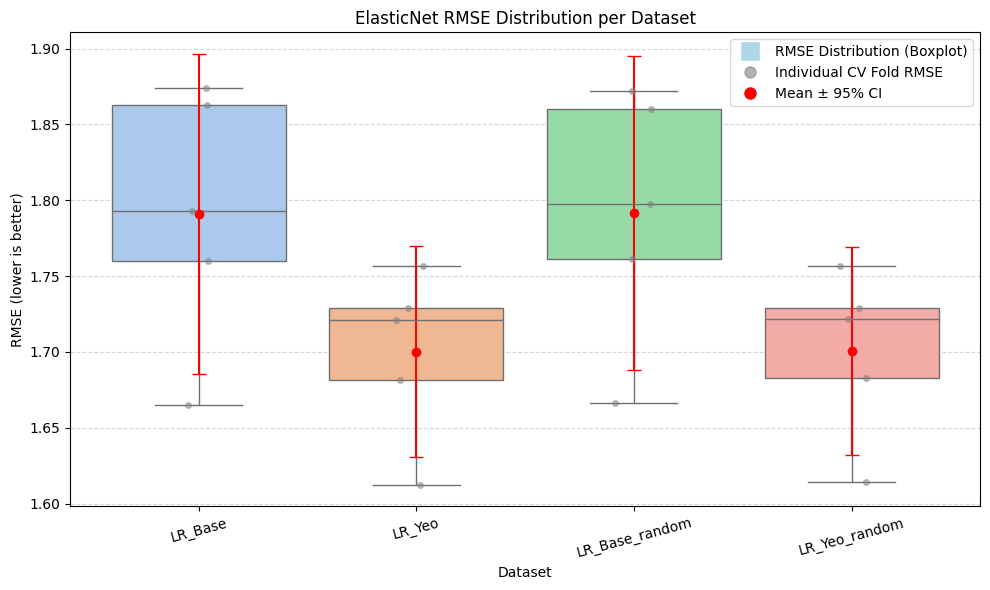

In [27]:
import seaborn as sns
plt.figure(figsize=(10, 6))

# Boxplot for RMSE distribution
box = sns.boxplot(x='Dataset', y='RMSE', data=rmse_df, palette='pastel')

# Stripplot for individual fold RMSEs
strip = sns.stripplot(x='Dataset', y='RMSE', data=rmse_df, color='gray', alpha=0.6, jitter=True)

# Plot mean and 95% CI as red points with error bars
for i, dataset in enumerate(rmse_df['Dataset'].unique()):
    rmse_vals = rmse_df[rmse_df['Dataset'] == dataset]['RMSE']
    mean = np.mean(rmse_vals)
    ci_low, ci_high = mean_confidence_interval(rmse_vals)[1:]
    err = plt.errorbar(i, mean, yerr=[[mean - ci_low], [ci_high - mean]],
                       fmt='o', color='red', capsize=5, label='Mean ± 95% CI' if i == 0 else "")

# Title and axes
plt.title('ElasticNet RMSE Distribution per Dataset')
plt.ylabel('RMSE (lower is better)')
plt.xlabel('Dataset')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='RMSE Distribution (Boxplot)',
           markerfacecolor='lightblue', markersize=15),
    Line2D([0], [0], marker='o', color='gray', label='Individual CV Fold RMSE',
           linestyle='None', markersize=8, alpha=0.6),
    Line2D([0], [0], marker='o', color='red', label='Mean ± 95% CI',
           linestyle='None', markersize=8)
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import numpy as np

# Manually define p-values between dataset pairs (based on your output)
# Format: ((group1, group2), p_value)
p_values = {
    ('LR_Base', 'LR_Yeo'): 0.0260,
    ('LR_Base', 'LR_Base_random'): 0.6376,
    ('LR_Base', 'LR_Yeo_random'): 0.0264,
    ('LR_Yeo', 'LR_Base_random'): 0.0223,
    ('LR_Yeo', 'LR_Yeo_random'): 0.2949,
    ('LR_Base_random', 'LR_Yeo_random'): 0.0227,
}

# Get order of groups as they appear in the plot
groups = ['LR_Base', 'LR_Yeo', 'LR_Base_random', 'LR_Yeo_random']
group_positions = {group: i for i, group in enumerate(groups)}


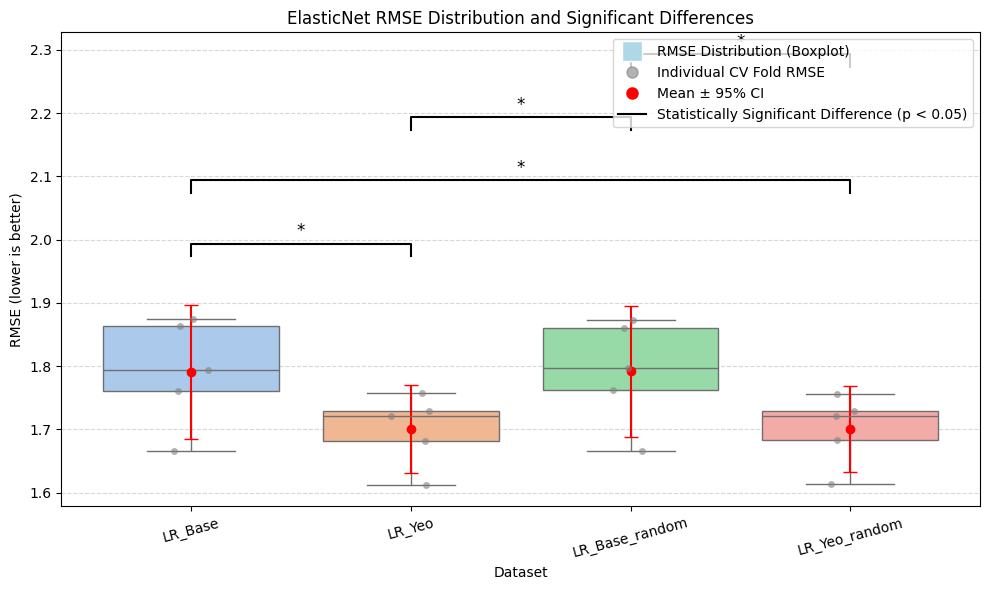

In [30]:
plt.figure(figsize=(10, 6))

# Base plot
sns.boxplot(x='Dataset', y='RMSE', data=rmse_df, palette='pastel')
sns.stripplot(x='Dataset', y='RMSE', data=rmse_df, color='gray', alpha=0.6, jitter=True)

# Add red dots with error bars for mean ± 95% CI
for i, group in enumerate(groups):
    rmse_vals = rmse_df[rmse_df['Dataset'] == group]['RMSE']
    mean = np.mean(rmse_vals)
    ci_low, ci_high = mean_confidence_interval(rmse_vals)[1:]
    plt.errorbar(i, mean, yerr=[[mean - ci_low], [ci_high - mean]], fmt='o', color='red', capsize=5)

# Add significance brackets for p < 0.05
def draw_sig_line(x1, x2, y, text):
    plt.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1.5, color='black')
    plt.text((x1 + x2) * 0.5, y + 0.025, text, ha='center', va='bottom', fontsize=12)

# Draw significance only for p < 0.05
y_max = rmse_df['RMSE'].max() + 0.1
height = y_max
spacing = 0.1

for (g1, g2), p in p_values.items():
    if p < 0.05:
        x1, x2 = group_positions[g1], group_positions[g2]
        draw_sig_line(x1, x2, height, '*')
        height += spacing  # stack brackets if overlapping

# Add legend manually
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='RMSE Distribution (Boxplot)', markerfacecolor='lightblue', markersize=15),
    Line2D([0], [0], marker='o', color='gray', label='Individual CV Fold RMSE', linestyle='None', markersize=8, alpha=0.6),
    Line2D([0], [0], marker='o', color='red', label='Mean ± 95% CI', linestyle='None', markersize=8),
    Line2D([0], [0], color='black', label='Statistically Significant Difference (p < 0.05)')
]
plt.legend(handles=legend_elements, loc='upper right')

# Styling
plt.title('ElasticNet RMSE Distribution and Significant Differences')
plt.ylabel('RMSE (lower is better)')
plt.xlabel('Dataset')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [31]:
# Step 1: RMSE summary table
rmse_summary = []

for i in range(len(summary_df)):
    name = summary_df.loc[i, 'dataset']
    rmse = summary_df.loc[i, 'rmse_folds']
    mean, ci_low, ci_high = mean_confidence_interval(rmse)
    rmse_summary.append({
        'Dataset': name,
        'Mean RMSE': round(mean, 3),
        '95% CI Lower': round(ci_low, 3),
        '95% CI Upper': round(ci_high, 3)
    })

rmse_summary_df = pd.DataFrame(rmse_summary)
print("\nRMSE Summary with 95% Confidence Intervals")
display(rmse_summary_df)



RMSE Summary with 95% Confidence Intervals


,Dataset,Mean RMSE,95% CI Lower,95% CI Upper
0,LR_Base,1.791,1.685,1.896
1,LR_Yeo,1.700,1.631,1.770
2,LR_Base_random,1.792,1.688,1.895
3,LR_Yeo_random,1.701,1.632,1.769


In [32]:
# Step 2: Paired t-test result table
from itertools import combinations

ttest_results = []

for (i, j) in combinations(range(len(summary_df)), 2):
    name_i = summary_df.loc[i, 'dataset']
    name_j = summary_df.loc[j, 'dataset']
    rmse_i = summary_df.loc[i, 'rmse_folds']
    rmse_j = summary_df.loc[j, 'rmse_folds']
    
    t_stat, p_val = ttest_rel(rmse_i, rmse_j)
    significance = '*' if p_val < 0.05 else ''
    
    ttest_results.append({
        'Model A': name_i,
        'Model B': name_j,
        't-statistic': round(t_stat, 3),
        'p-value': round(p_val, 4),
        'Significant?': significance
    })

ttest_df = pd.DataFrame(ttest_results)
print("\nPairwise t-test Results (Significance: * if p < 0.05)")
display(ttest_df)



Pairwise t-test Results (Significance: * if p < 0.05)


,Model A,Model B,t-statistic,p-value,Significant?
0,LR_Base,LR_Yeo,3.452,0.0260,*
1,LR_Base,LR_Base_random,-0.509,0.6376,
2,LR_Base,LR_Yeo_random,3.435,0.0264,*
3,LR_Yeo,LR_Base_random,-3.622,0.0223,*
4,LR_Yeo,LR_Yeo_random,-1.204,0.2949,
5,LR_Base_random,LR_Yeo_random,3.603,0.0227,*


Plot saved as: vif/elasticnet_rmse_distribution.png


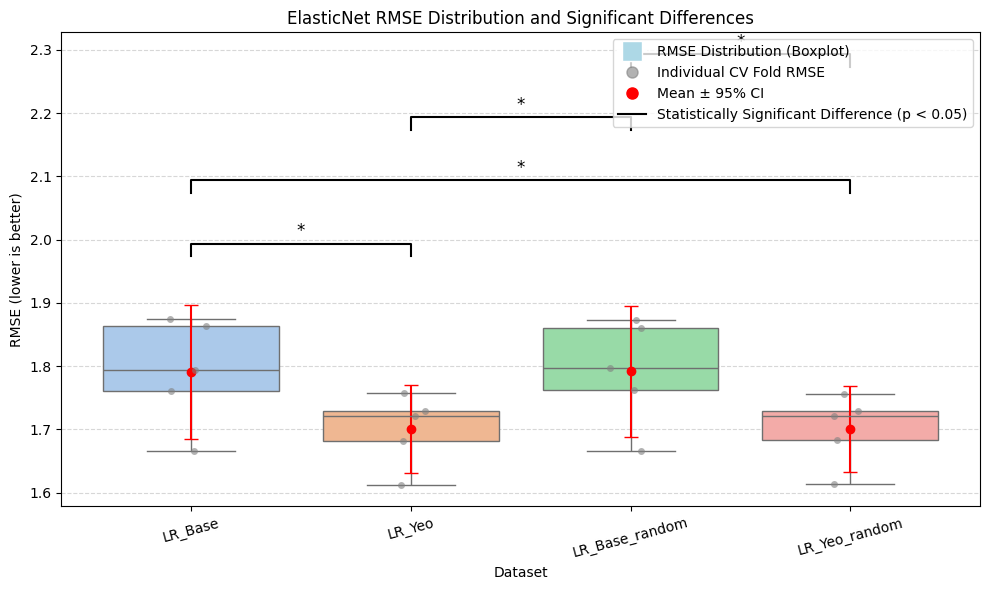

In [33]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# === Create plot ===
plt.figure(figsize=(10, 6))

# Base plot
sns.boxplot(x='Dataset', y='RMSE', data=rmse_df, palette='pastel')
sns.stripplot(x='Dataset', y='RMSE', data=rmse_df, color='gray', alpha=0.6, jitter=True)

# Add red dots with error bars for mean ± 95% CI
for i, group in enumerate(groups):
    rmse_vals = rmse_df[rmse_df['Dataset'] == group]['RMSE']
    mean = np.mean(rmse_vals)
    ci_low, ci_high = mean_confidence_interval(rmse_vals)[1:]
    plt.errorbar(i, mean, yerr=[[mean - ci_low], [ci_high - mean]], fmt='o', color='red', capsize=5)

# Add significance brackets for p < 0.05
def draw_sig_line(x1, x2, y, text):
    plt.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1.5, color='black')
    plt.text((x1 + x2) * 0.5, y + 0.025, text, ha='center', va='bottom', fontsize=12)

# Draw significance only for p < 0.05
y_max = rmse_df['RMSE'].max() + 0.1
height = y_max
spacing = 0.1

for (g1, g2), p in p_values.items():
    if p < 0.05:
        x1, x2 = group_positions[g1], group_positions[g2]
        draw_sig_line(x1, x2, height, '*')
        height += spacing  # stack brackets if overlapping

# Add legend manually
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='RMSE Distribution (Boxplot)', markerfacecolor='lightblue', markersize=15),
    Line2D([0], [0], marker='o', color='gray', label='Individual CV Fold RMSE', linestyle='None', markersize=8, alpha=0.6),
    Line2D([0], [0], marker='o', color='red', label='Mean ± 95% CI', linestyle='None', markersize=8),
    Line2D([0], [0], color='black', label='Statistically Significant Difference (p < 0.05)')
]
plt.legend(handles=legend_elements, loc='upper right')

# Styling
plt.title('ElasticNet RMSE Distribution and Significant Differences')
plt.ylabel('RMSE (lower is better)')
plt.xlabel('Dataset')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# === Save the plot ===
output_dir = "vif"
os.makedirs(output_dir, exist_ok=True)
filename = "elasticnet_rmse_distribution.png"
file_path = os.path.join(output_dir, filename)
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# Confirmation message
print(f"Plot saved as: {file_path}")

# Optional: show the plot
plt.show()
